In [2]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import bs4
import pandas as pd
from bs4 import BeautifulSoup
import re
import multiprocessing
from multiprocessing import Pool 

In [5]:
page_content = requests.get("https://fr.openfoodfacts.org/1").content
soup = BeautifulSoup(page_content, 'lxml')

def recup_produits(soup):
    li = []
  
    for x in soup.findAll(href=re.compile("/produit")):
        dic = {}
        dic["lien"] = "https://fr.openfoodfacts.org/"+x["href"]
        dic["nom"] =  x["href"].split("/")[-1].replace('-', ' ')
        li.append(dic)
    return li
len(recup_produits(soup))

100

In [8]:
def iter_page():
    i = 0
    li = []
    while True:
        i+=1
        page_content = requests.get(f"https://fr.openfoodfacts.org/{i}").content
        soup = BeautifulSoup(page_content, 'lxml')
        result = recup_produits(soup)
        if len(result)==0:
            break
        elif  i > 3 :
            break
            
        else:
            print(i)
            pass
            li += result   
    return li
li = iter_page()
        
len(li)   


1
2
3


300

In [8]:
len(li)

500

In [157]:
# Stocker l'ensemble des liens récupérés par la fonction iter_page dans une liste
url = []  
for i in range(len(li)) :
    l = li[i].get("lien").strip()
    url.append(l)
    

In [85]:
len(url)

500

####  Une fois tous les liens récupérés, on peut alors chercher les informations demandées une par une et chaque produit

In [158]:
r= requests.get('https://fr.openfoodfacts.org/produit/3017620425035/nutella-ferrero')
soup1=BeautifulSoup(r.text,'html.parser')

In [159]:
soup1.find("h1").text.replace('\xa0',"") # Le nom du produit

'Nutella - Ferrero - 1kg'

In [160]:
soup1.find("span", attrs={"id":"barcode"}).text.replace('\xa0',"") # Le code barre

'3017620425035'

#### On trouve les information demandées une par une

In [161]:
# Trouver le Conditionnement, la Marque, les Catégories, les Labels, l'Origine, le Lieu de Fabrication,
# le Code de Traçabilité, le Lien vers le site du produit, le Magasin, le Pays de Vente
s2 = soup1.find_all('a')
Conditionnement = ''
Marque = ''
Categorie = ''
Label = ''
Origine = ''
Lieu_Fabrication = ''
Code = ''
#Lien = ''
Magasin = ''
Pays_Vente = ''
Additif = ''
Ingredien_Huile_Palme = ''
for i in range(len(s2)):
    try:
        if s2[i]['href'].startswith('/conditionnement/'):
            Conditionnement+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/marque/'):  
             Marque+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/categorie/'): 
            Categorie+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/label/'):
            Label+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/origine/'): 
            Origine+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/lieu-de-fabrication/'):
            Lieu_Fabrication+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/code-emballeur/'):
            Code+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/magasin/'):
            Magasin+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/pays/'): 
            Pays_Vente+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/additif/'):
            Additif+=soup1.find_all('a')[i].text +','
        elif s2[i]['href'].startswith('/ingredients-issus-de-l-huile-de-palme/'): 
            Ingredien_Huile_Palme+=soup1.find_all('a')[i].text +','
            
    except:
        pass

In [17]:
Conditionnement,Marque,Categorie,Pays_Vente

('Pot,Verre,Couvercle,Plastique,Carton,Plaque,',
 'Ferrero,Nutella,',
 'Produits à tartiner,Petit-déjeuners,Produits à tartiner sucrés,Pâtes à tartiner,Pâtes à tartiner aux noisettes,Pâtes à tartiner au chocolat,Pâtes à tartiner aux noisettes et au cacao, (778 produits), (916 produits), (1022 produits), (1781 produits), (15325 produits), (20886 produits), (25808 produits),',
 'Algérie,Belgique,France,Allemagne,Guadeloupe,Italie,Luxembourg,Martinique,Maroc,La Réunion,Suisse,')

In [70]:
len(s2)

232

In [162]:
def produit(lien) : 
    prod = []
    
    for l in lien :
        r= requests.get(l)
        soupe=BeautifulSoup(r.text,'html.parser')
        Nom_Produit = soupe.find("h1").text.replace('\xa0',"") if soupe.find("h1") else ''
        Code_Barre = soupe.find("span", attrs={"id":"barcode"}).text.replace('\xa0',"") if soupe.find("span", attrs={"id":"barcode"}) else ''
        #Comparaison = soupe.find_all("label")[8].text.strip() if soupe.find_all("label")[8] else ''
        #Energie_kcal = soupe.find("tr", attrs = {"id" : "nutriment_energy-kcal_tr"}).find_all("td")[1].text.replace("kcal","").strip() if soupe.find("tr", attrs = {"id" : "nutriment_energy-kcal_tr"}) else ''
        #NB_Calorie = soupe.find("tr", attrs = {"id" : "nutriment_energy_tr"}).find_all("td")[1].text.strip().replace("\xa0","")[0:4] if soupe.find("tr", attrs = {"id" : "nutriment_energy_tr"}) else ''
        s=soupe.find_all('img')
        Nutriscore = ''
        Nova=''
        Ecoscore = ''
        for i in range(len(s)):
            try:
                if s[i]['alt'].endswith('minimalement'):
                    Nova += s[i]["alt"]  #.replace("Note nutritionnelle NutriScore :","").strip()
                elif s[i]['alt'].endswith('culinaires transformés') :
                    Nova += s[i]["alt"]
                elif s[i]['alt'].endswith('Aliments transformés') :
                    Nova += s[i]["alt"]
                elif s[i]['alt'].endswith('ultra-transformés') :
                    Nova += s[i]["alt"]
                elif s[i]['alt'].startswith('Eco-score'):
                    Ecoscore += s[i]["alt"]
                elif s[i]['alt'].startswith('Note'):
                    Nutriscore += s[i]["alt"].replace("Note nutritionnelle NutriScore :","").strip()
            except:
                pass      
        prod.append((Nom_Produit,Code_Barre,Nutriscore,Nova,Ecoscore)) #Comparaison,Energie_kcal,NB_Calorie)) 
        F1 = pd.DataFrame(prod, columns=['Nom_Produit','Code_Barre', 'Nutriscore','Nova','Ecoscore'])
                                            #'Comparaison','Energie_kcal','NB_Calorie'])
    return F1 

In [163]:
import time
from multiprocessing import Process  
if __name__ == "__main__":
    start_time = time.time()
    p = Process(target=produit(url))  
    p.start()
    p.join()
    print("Temps d'éxecution : "+"%s seconds" % (time.time() - start_time))
    F1 = produit(url)
    
    

Temps d'éxecution : 188.95611000061035 seconds


In [20]:
F1

,Nom_Produit,Code_Barre,Nutriscore,Nova,Ecoscore
0,"Cristaline Eau de source - 1,5l",3274080005003,A,1 - Aliments non transformés ou transformés mi...,
1,Nutella - Ferrero - 400g,3017620422003,E,4 - Produits alimentaires et boissons ultra-tr...,Eco-score D
2,Prince Chocolat - Lu - 300g,7622210449283,D,4 - Produits alimentaires et boissons ultra-tr...,Eco-score D
3,Coca-Cola - 330ml,5449000000996,E,4 - Produits alimentaires et boissons ultra-tr...,
4,Nutella - Ferrero - 1kg,3017620425035,E,4 - Produits alimentaires et boissons ultra-tr...,Eco-score D
...,...,...,...,...,...
495,Cookies pepites chocolat - Bonne Maman - 250g,3178530407396,E,4 - Produits alimentaires et boissons ultra-tr...,Eco-score D
496,Muesli floconneux 30% fruits secs - Carrefour ...,3270190136835,A,4 - Produits alimentaires et boissons ultra-tr...,Eco-score A
497,Excellence - Chocolat noir orange intense aux ...,3046920022705,E,4 - Produits alimentaires et boissons ultra-tr...,
498,Cassonade - Saint-Louis - 1kg,3220035210008,D,2 - Ingrédients culinaires transformés,Eco-score B


In [164]:
# Okay
def info(links):
    b = []
    for l in links :
        r= requests.get(l)
        soupe=BeautifulSoup(r.text,'html.parser')
        s3 = soupe.find_all('a')
        Conditionnement = ''
        Marque = ''
        Categorie = ''
        Label = ''
        Origine = ''
        Lieu_Fabrication = ''
        Code = ''
        #Lien = ''
        Magasin = ''
        Pays_Vente = ''
        Additif = ''
        Ingredien_Huile_Palme = ''
        for i in range(len(s3)):
            try:
                if s3[i]['href'].startswith('/conditionnement/'):
                    Conditionnement+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/marque/'):  
                     Marque+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/categorie/'): 
                    Categorie+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/label/'):
                    Label+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/origine/'): 
                    Origine+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/lieu-de-fabrication/'):
                    Lieu_Fabrication+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/code-emballeur/'):
                    Code+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/magasin/'):
                    Magasin+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/pays/'): 
                    Pays_Vente+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/additif/'):
                    Additif+=soupe.find_all('a')[i].text +','
                elif s3[i]['href'].startswith('/ingredients-issus-de-l-huile-de-palme/'): 
                    Ingredien_Huile_Palme+=soupe.find_all('a')[i].text +','
            
            except :
                pass
        b.append((Conditionnement,Marque,Categorie,Label,Origine,Lieu_Fabrication,Code,Magasin,Pays_Vente,
                 Additif,Ingredien_Huile_Palme))
        F2 = pd.DataFrame(b, columns=['Conditionnement','Marque','Categorie','Label','Origine',
                                         'Lieu_Fabrication','Code','Magasin','Pays_Vente','Additif',
                                         'Ingredien_Huile_Palme'])
    return F2

In [165]:
import time
from multiprocessing import Process  
if __name__ == "__main__":
    start_time = time.time()
    p = Process(target=info(url))  
    p.start()
    p.join()
    print("Temps d'éxecution : "+"%s seconds" % (time.time() - start_time))
    F2 = info(url)
    
    

Temps d'éxecution : 152.92081379890442 seconds


In [23]:
F2

,Conditionnement,Marque,Categorie,Label,Origine,Lieu_Fabrication,Code,Magasin,Pays_Vente,Additif,Ingredien_Huile_Palme
0,"Bouteille,Plastique,Bouchon,","Cristaline,","Boissons,Eaux,Eaux de sources,Eaux minérales,E...","Point Vert,en:Triman,Sans nitrate,","France,","France,72370,Ardenay-sur-Merize,","EMB 44068A,EMB 59457,EMB 72007B,","Carrefour,Leclerc,Auchan,","Côte d'Ivoire,France,Guadeloupe,Italie,Luxembo...",,
1,"Verre,Couvercle,Plastique,Pot,Opercule,Plaque ...","Ferrero,Nutella,","Produits à tartiner,Petit-déjeuners,Aides culi...","Sans gluten,Point Vert,","Australie,Brésil,Chili,Côte d'Ivoire,Ghana,Ind...","France,","NON COMMUNIQUÉ,","Bi1,Magasins U,Carrefour,Franprix,Auchan,","Algérie,Autriche,Belgique,Canada,France,Allema...","E322 - Lécithines,","Huile de palme,"
2,"Plastique,Film en plastique,Paquet,Mondelez,Et...","Lu,","Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...","Sans conservateurs,",,,,"Carrefour Market,Magasins U,Auchan,Intermarché...","Algérie,Belgique,France,Polynésie française,Al...","E503ii - Carbonate acide d'ammonium,E500ii - C...","Huile de palme,"
3,"aluminium-can,","Coca-cola,","Boissons,Boissons gazeuses,Sodas,Sodas au cola...","en:Verified,",,,,"Tesco,Auchan,Carrefour,","Algérie,Andorre,Autriche,Belgique,Brésil,Camer...","E290 - Dioxyde de carbone,E150d - Caramel au s...",
4,"Pot,Verre,Couvercle,Plastique,Carton,Plaque,","Ferrero,Nutella,","Produits à tartiner,Petit-déjeuners,Produits à...","Point Vert,",,,,"Auchan,","Algérie,Belgique,France,Allemagne,Guadeloupe,I...","E322 - Lécithines,","Huile de palme,"
...,...,...,...,...,...,...,...,...,...,...,...
495,"Sachet,Plastique,Film plastique à jeter,sachet...","Bonne Maman,","Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...",,,,,"Super U,Magasins U,","Belgique,France,Luxembourg,Suisse,","E322i - Lécithine,E500 - Carbonates de sodium,...",
496,"Carton,sous atmosphère protectrice,","Carrefour Bio,Carrefour,","Aliments et boissons à base de végétaux,Alimen...","Peu ou pas de sucre,Bio,Bio européen,Agricultu...",,"France,","EMB 42289A,","Carrefour,","France,Maroc,Espagne,Bélgica,Francia,Guadalupe...",,
497,"Carton,Tablette,Etui en carton,Sec,Aluminium,","LindtLindt Excellence,","Snacks,en:Aide culinaire sucrée,en:Aides culin...","en:Agriculture durable,en:Fabriqué en France,e...","en:Agnos,en:Bidos,en:Estos,en:France Oloron-S...","France,64400 Oloron-Sainte-Marie,",,"Magasins U,Auchan,Carrefour,Cora,Franprix,E.le...","Canada,France,en:en,","E322i - Lécithine,E440 - Pectines,",
498,"Carton,Etui en carton,","Saint-Louis,","Édulcorants,Sucres,Sucres roux,Sucres de canne...","en:FSC,FSC Mix,Point Vert,",,,"EMB 80685C,FSC-C126270,","Super U,Magasins U,Carrefour,Intermarché,","France,Suisse,",,


In [166]:
def calorie(lien):
    cal = []
    
    for l in lien :
        r= requests.get(l)
        soup1=BeautifulSoup(r.text,'html.parser')
        Energy_Kcal = ''
        NB_Calorie = ''
        s3=soup1.find_all('tr')
        for i in range(len(s3)):
            try:
                if s3[i]['id'].startswith('nutriment_energy-kcal_tr'):
                    Energy_Kcal += soup1.find("tr", attrs = {"id" : "nutriment_energy-kcal_tr"}).find_all("td")[1].text.replace("kcal","").strip()
                elif s3[i]['id'].startswith('nutriment_energy_tr'): 
                    NB_Calorie += soup1.find("tr", attrs = {"id" : "nutriment_energy_tr"}).find_all("td")[1].text.strip().replace("\xa0","")[0:4]
            except:
                pass
        cal.append((Energy_Kcal,NB_Calorie))
        F3 = pd.DataFrame(cal, columns=['Energy_Kcal','NB_Calorie'])
    return F3

In [167]:
import time
from multiprocessing import Process  
if __name__ == "__main__":
    start_time = time.time()
    p = Process(target=info(url))  
    p.start()
    p.join()
    print("Temps d'éxecution : "+"%s seconds" % (time.time() - start_time))
    F3 = calorie(url)
    
    

Temps d'éxecution : 149.648823261261 seconds


In [168]:
F3

,Energy_Kcal,NB_Calorie
0,0,0 kj
1,539,2252
2,465,1955
3,42,180
4,539,2252
...,...,...
495,507,2121
496,342,1431
497,525,2197
498,396,1683


In [169]:
Food = pd.concat([F1, F2, F3],axis = 1)
Food.tail()

,Nom_Produit,Code_Barre,Nutriscore,Nova,Ecoscore,Conditionnement,Marque,Categorie,Label,Origine,Lieu_Fabrication,Code,Magasin,Pays_Vente,Additif,Ingredien_Huile_Palme,Energy_Kcal,NB_Calorie
495,Cookies pepites chocolat - Bonne Maman - 250g,3178530407396,E,4 - Produits alimentaires et boissons ultra-tr...,Eco-score D,"Sachet,Plastique,Film plastique à jeter,sachet...","Bonne Maman,","Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...",,,,,"Super U,Magasins U,","Belgique,France,Luxembourg,Suisse,","E322i - Lécithine,E500 - Carbonates de sodium,...",,507,2121
496,Muesli floconneux 30% fruits secs - Carrefour ...,3270190136835,A,4 - Produits alimentaires et boissons ultra-tr...,Eco-score A,"Carton,sous atmosphère protectrice,","Carrefour Bio,Carrefour,","Aliments et boissons à base de végétaux,Alimen...","Peu ou pas de sucre,Bio,Bio européen,Agricultu...",,"France,","EMB 42289A,","Carrefour,","France,Maroc,Espagne,Bélgica,Francia,Guadalupe...",,,342,1431
497,Excellence - Chocolat noir orange intense aux ...,3046920022705,E,4 - Produits alimentaires et boissons ultra-tr...,,"Carton,Tablette,Etui en carton,Sec,Aluminium,","LindtLindt Excellence,","Snacks,en:Aide culinaire sucrée,en:Aides culin...","en:Agriculture durable,en:Fabriqué en France,e...","en:Agnos,en:Bidos,en:Estos,en:France Oloron-S...","France,64400 Oloron-Sainte-Marie,",,"Magasins U,Auchan,Carrefour,Cora,Franprix,E.le...","Canada,France,en:en,","E322i - Lécithine,E440 - Pectines,",,525,2197
498,Cassonade - Saint-Louis - 1kg,3220035210008,D,2 - Ingrédients culinaires transformés,Eco-score B,"Carton,Etui en carton,","Saint-Louis,","Édulcorants,Sucres,Sucres roux,Sucres de canne...","en:FSC,FSC Mix,Point Vert,",,,"EMB 80685C,FSC-C126270,","Super U,Magasins U,Carrefour,Intermarché,","France,Suisse,",,,396,1683
499,NESCAFE SPECIAL FILTRE L'Original Flacon de - ...,3033710074525,,1 - Aliments non transformés ou transformés mi...,Eco-score E,"Boite,Plastique,","Nestlé,Nescafe,Special filtre,","Aliments et boissons à base de végétaux,Boisso...","Point Vert,",,,,"Magasins U,","Belgique,France,Suisse,",,,?,


   ###                                              Partie Analyse

In [170]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [171]:
data = Food.loc[:,['Nutriscore','Ecoscore','Nova']]
data

,Nutriscore,Ecoscore,Nova
0,A,,1 - Aliments non transformés ou transformés mi...
1,E,Eco-score D,4 - Produits alimentaires et boissons ultra-tr...
2,D,Eco-score D,4 - Produits alimentaires et boissons ultra-tr...
3,E,,4 - Produits alimentaires et boissons ultra-tr...
4,E,Eco-score D,4 - Produits alimentaires et boissons ultra-tr...
...,...,...,...
495,E,Eco-score D,4 - Produits alimentaires et boissons ultra-tr...
496,A,Eco-score A,4 - Produits alimentaires et boissons ultra-tr...
497,E,,4 - Produits alimentaires et boissons ultra-tr...
498,D,Eco-score B,2 - Ingrédients culinaires transformés


####  Distribution du nombre de produits par catégorie Nutri Score, Nova et Eco score

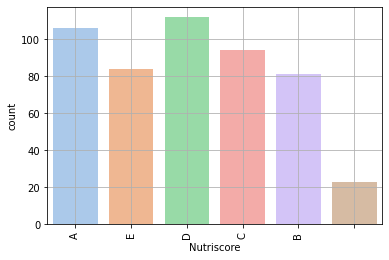

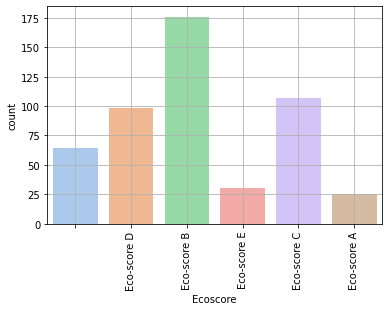

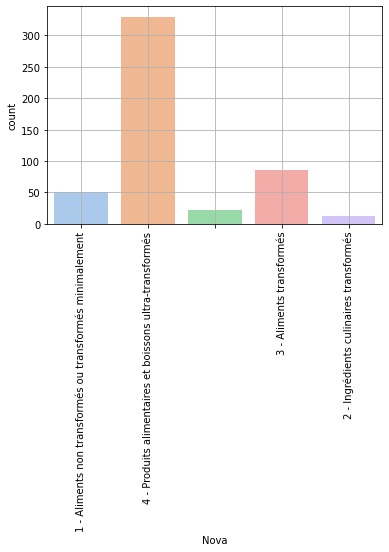

In [172]:
for col in range(0,3):
    plt.figure(col)
    dplot=sns.countplot(x=data.columns[col],palette='pastel',data=data)
    dplot.set_xticklabels(dplot.get_xticklabels(), rotation=90)
    plt.grid()
    dplot

#### Liste des produits ayant “gluten free” optimaux (Nutri score A, Nova 1 et Ecoscore A)

In [173]:
data1 = Food.loc[:,['Nom_Produit','Nutriscore','Ecoscore','Nova']]

In [174]:
data2 = data1[(data1['Nutriscore']=='A') & (data1['Ecoscore']=='Eco-score A') & (data1['Nova']=='1 - Aliments non transformés ou transformés minimalement')]

In [175]:
data2

,Nom_Produit,Nutriscore,Ecoscore,Nova
387,Panzani tomacouli nature - 200g,A,Eco-score A,1 - Aliments non transformés ou transformés mi...
388,Boisson végétale soja sans sucres - Bjorg - 1L,A,Eco-score A,1 - Aliments non transformés ou transformés mi...


### Liste des produits dont le nombre de calories pour 100g est supérieur à 500.

In [176]:
Produit_Calorie = Food.loc[:,['Nom_Produit','NB_Calorie']]

In [177]:
Produit_Calorie['NB_Calorie']=Produit_Calorie['NB_Calorie'].str.replace("kj","").str.replace("k","").str.replace("j","").str.replace("","")

In [178]:
Produit_Calorie['NB_Calorie'].describe()

count      500
unique     371
top       2252
freq        13
Name: NB_Calorie, dtype: object

In [179]:
Produit_Calorie['NB_Calorie']=Produit_Calorie['NB_Calorie'].str.replace(',','.').str.replace('?','')

In [181]:
Produit_Calorie['NB_Calorie'] = pd.to_numeric(Produit_Calorie['NB_Calorie'])
#(Produit_Calorie['NB_Calorie'][191]).replace(",",".")

In [44]:
Produit_Calorie['NB_Calorie'].describe()

count     489.000000
mean     1401.578119
std       806.919914
min         0.000000
25%       777.000000
50%      1586.000000
75%      1929.000000
max      6556.000000
Name: NB_Calorie, dtype: float64

### Le tableau ci dessous donne la liste des produits pour lesquels le nombre de calories est supérieur à 500

In [182]:
data3 = Produit_Calorie[Produit_Calorie['NB_Calorie'] > 500  ]
data3

,Nom_Produit,NB_Calorie
1,Nutella - Ferrero - 400g,2252.0
2,Prince Chocolat - Lu - 300g,1955.0
4,Nutella - Ferrero - 1kg,2252.0
5,"Muesli Raisin, Figue, Abricot - Bjorg - 375g ℮",1440.0
6,Biscuit Sésame - Gerblé - 230g,2025.0
...,...,...
493,Moelleux chocolat et noix - gerblé - 138g,1816.0
495,Cookies pepites chocolat - Bonne Maman - 250g,2121.0
496,Muesli floconneux 30% fruits secs - Carrefour ...,1431.0
497,Excellence - Chocolat noir orange intense aux ...,2197.0


### Liste des produits contenant de l’huile de palme, vendu en France et en Belgique

In [183]:
Produit_Huile = Food.loc[:,['Nom_Produit','Ingredien_Huile_Palme', 'Pays_Vente']]

In [184]:
Produit_Huile.tail()

,Nom_Produit,Ingredien_Huile_Palme,Pays_Vente
495,Cookies pepites chocolat - Bonne Maman - 250g,,"Belgique,France,Luxembourg,Suisse,"
496,Muesli floconneux 30% fruits secs - Carrefour ...,,"France,Maroc,Espagne,Bélgica,Francia,Guadalupe..."
497,Excellence - Chocolat noir orange intense aux ...,,"Canada,France,en:en,"
498,Cassonade - Saint-Louis - 1kg,,"France,Suisse,"
499,NESCAFE SPECIAL FILTRE L'Original Flacon de - ...,,"Belgique,France,Suisse,"


In [49]:
Produit_Huile['Ingredien_Huile_Palme']

0                     
1      Huile de palme,
2      Huile de palme,
3                     
4      Huile de palme,
            ...       
495                   
496                   
497                   
498                   
499                   
Name: Ingredien_Huile_Palme, Length: 500, dtype: object

In [196]:
Pays = []
for e in range(500):
    if (Produit_Huile['Pays_Vente'][e].startswith('France') | Produit_Huile['Pays_Vente'][e].startswith('Belgique')):
        print(Produit_Huile['Pays_Vente'][e])
        Produits = Produit_Huile['Nom_Produit'][e]
        Ingredient = Produit_Huile['Ingredien_Huile_Palme'][e]
        Pays_De_Vente = Produit_Huile['Pays_Vente'][e]
        Pays.append((Produits,Ingredient,Pays_De_Vente)) 
        PAYS_PRO = pd.DataFrame(Pays, columns=['Produits','Ingredient','Pays_De_Vente'])
        

Belgique,Côte d'Ivoire,France,Polynésie française,Guadeloupe,Italie,Martinique,Maroc,Nouvelle-Calédonie,La Réunion,Espagne,Suisse,
Belgique,France,Guadeloupe,Martinique,Maroc,La Réunion,Suisse,
Belgique,France,Luxembourg,Martinique,La Réunion,Suisse,
France,
Belgique,France,Polynésie française,Guadeloupe,Martinique,Maroc,Nouvelle-Calédonie,La Réunion,Espagne,Suisse,
Belgique,France,Polynésie française,Guadeloupe,Italie,Luxembourg,La Réunion,Suisse,
Belgique,France,Luxembourg,Martinique,La Réunion,Suisse,
Belgique,France,Maroc,Nouvelle-Calédonie,Espagne,Suisse,
France,Luxembourg,Suisse,
Belgique,France,Polynésie française,Italie,Martinique,Espagne,Suisse,
Belgique,France,Suisse,Royaume-Uni,États-Unis,
Belgique,France,Guadeloupe,Martinique,Maroc,La Réunion,Sénégal,Suisse,
Belgique,Côte d'Ivoire,France,Polynésie française,Gabon,Guadeloupe,Martinique,Maroc,Nouvelle-Calédonie,La Réunion,Sénégal,Espagne,Suisse,
Belgique,France,Polynésie française,Guadeloupe,Italie,Martinique,La Réunion,Espag

In [197]:
PAYS_PRO

,Produits,Ingredient,Pays_De_Vente
0,"Muesli Raisin, Figue, Abricot - Bjorg - 375g ℮",,"Belgique,Côte d'Ivoire,France,Polynésie frança..."
1,Biscuit Sésame - Gerblé - 230g,,"Belgique,France,Guadeloupe,Martinique,Maroc,La..."
2,100% mie complet - Harrys - 500g,,"Belgique,France,Luxembourg,Martinique,La Réuni..."
3,Soupe 3 poissons aux algues - Sainte Barbe,,"France,"
4,NESTLE CHOCAPIC Céréales Petit Déjeuner - 430g,,"Belgique,France,Polynésie française,Guadeloupe..."
...,...,...,...
436,Capri-Sun - 200ml,,"Belgique,France,Suisse,"
437,Cookies pepites chocolat - Bonne Maman - 250g,,"Belgique,France,Luxembourg,Suisse,"
438,Muesli floconneux 30% fruits secs - Carrefour ...,,"France,Maroc,Espagne,Bélgica,Francia,Guadalupe..."
439,Cassonade - Saint-Louis - 1kg,,"France,Suisse,"


In [198]:
PAYS_PRO=PAYS_PRO[PAYS_PRO['Ingredient']=='Huile de palme,']

In [204]:
PAYS_PRO

,Produits,Ingredient,Pays_De_Vente
17,Biscottes 6 Céréales - Heudebert - 300g e,Huile de palme,Belgique France La Réunion Suisse
18,Primevère Bio doux Tartine & Cuisson - 250g,Huile de palme,France Guadeloupe La Réunion
56,Patamilka aux noisettes - Milka - 600g,Huile de palme,Belgique France La Réunion
61,Cracotte Céréales Complètes - lu - 250,Huile de palme,Belgique France Luxembourg La Réunion Suisse
62,Céréales Extra Pepites Kellogg's Chocolat Nois...,Huile de palme,Belgique France Guadeloupe Italie Luxembourg M...
79,Cracotte - LU - 250g (2x 18),Huile de palme,Belgique France Luxembourg Suisse
80,Napolitain l'Original - Lu - 6x 30g,Huile de palme,Belgique France Luxembourg Pays-Bas
83,Pain grillé de campagne Blé complet - Pelletie...,Huile de palme,France La Réunion Suisse
94,Thé - Biscuits - Lu thé - 350g ℮,Huile de palme,France Nouvelle-Calédonie La Réunion Suisse
109,Krisprolls - 425g,Huile de palme,France


In [205]:
spi = list(PAYS_PRO['Pays_De_Vente'])
decoup = []
for i in range(len(spi)) :
    ap = spi[i].split()
    sp = ap
    spli = len(ap)
    decoup.append(spli)

In [210]:
dec = pd.DataFrame(decoup, columns=['NB_PAYS'])
#dec


In [218]:
PAYS_PRO=PAYS_PRO.reset_index(drop = True)

In [220]:
P= pd.concat([PAYS_PRO,dec],axis=1)

In [221]:
P

,Produits,Ingredient,Pays_De_Vente,NB_PAYS
0,Biscottes 6 Céréales - Heudebert - 300g e,Huile de palme,Belgique France La Réunion Suisse,5
1,Primevère Bio doux Tartine & Cuisson - 250g,Huile de palme,France Guadeloupe La Réunion,4
2,Patamilka aux noisettes - Milka - 600g,Huile de palme,Belgique France La Réunion,4
3,Cracotte Céréales Complètes - lu - 250,Huile de palme,Belgique France Luxembourg La Réunion Suisse,6
4,Céréales Extra Pepites Kellogg's Chocolat Nois...,Huile de palme,Belgique France Guadeloupe Italie Luxembourg M...,10
5,Cracotte - LU - 250g (2x 18),Huile de palme,Belgique France Luxembourg Suisse,4
6,Napolitain l'Original - Lu - 6x 30g,Huile de palme,Belgique France Luxembourg Pays-Bas,4
7,Pain grillé de campagne Blé complet - Pelletie...,Huile de palme,France La Réunion Suisse,4
8,Thé - Biscuits - Lu thé - 350g ℮,Huile de palme,France Nouvelle-Calédonie La Réunion Suisse,5
9,Krisprolls - 425g,Huile de palme,France,1


Text(0.5, 1.0, 'Représentation des Produits Par Nombre de Pays')

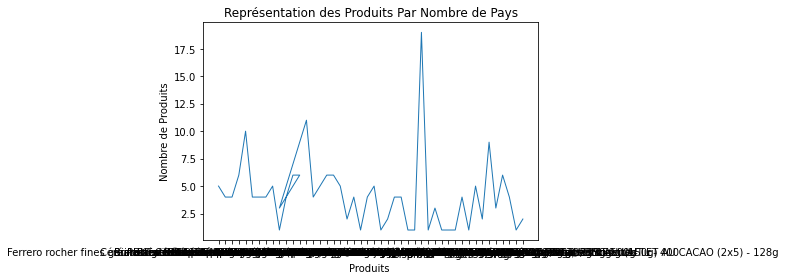

In [230]:
plt.plot(P["Produits"], P['NB_PAYS'],linewidth=1)
plt.xlabel('Produits ')
plt.ylabel('Nombre de Produits')
plt.title('Représentation des Produits Par Nombre de Pays')